In [1]:
%reset -sf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import get_data as gd
import atlas_plot as ap
import gc

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2023-11-23 06:40:22.013530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [2]:
processor = gd.DataProcessor()
path = "/root/work/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

['/root/work/truth/signal/CGLMP.npz', '/root/work/truth/signal/Higgs.npz', '/root/work/truth/signal/LeadLepton.npz', '/root/work/truth/signal/LeptonM.npz', '/root/work/truth/signal/LeptonP.npz', '/root/work/truth/signal/LmNu.npz', '/root/work/truth/signal/LpNu.npz', '/root/work/truth/signal/MET.npz', '/root/work/truth/signal/WmBoson.npz', '/root/work/truth/signal/WpBoson.npz', '/root/work/truth/signal/diLepton.npz', '/root/work/truth/signal/subLeadLepton.npz', '/root/work/truth/signal/xi_xyz.npz']



In [3]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [4]:
# y -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
MET_kin = pd.concat([MET, lep_kin], axis=1)
print("MET_kin shape:", MET_kin.shape)
print(MET_kin.head(3))
print()

# x -> interested unknowns
dinu_kin = pd.DataFrame(processor.process_dipart(data.LepP, data.LepM)["pz"][cut_pre])
print("dinu_kin shape:", dinu_kin.shape)
print(dinu_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

MET_kin shape: (1378510, 10)
       MET_px     MET_py           E         px         py          pz  \
7   96.335650  47.095450   19.500895  -4.561588  18.924410   -1.154271   
9  -26.992604 -70.883859  164.814766  34.397141   2.031300 -161.172625   
10  44.222846 -15.383637   47.669113 -26.605045 -17.256748   35.590859   

            E         px         py         pz  
7   43.361348  42.407754  -4.632000   7.767462  
9   70.592648  29.001777   1.896990 -64.332027  
10  90.238664 -23.868604  32.986602  80.530680  

dinu_kin shape: (1378510, 1)
            pz
7     6.613191
9  -225.504652
10  116.121539



0

In [5]:
from sklearn.preprocessing import StandardScaler

SCALAR_int = StandardScaler()
norm_var = SCALAR_int.fit_transform(dinu_kin)
dinu_kin = norm_var

SCALAR_MET = StandardScaler()
norm_var = SCALAR_MET.fit_transform(MET_kin)
MET_kin = norm_var

del norm_var

from sklearn.model_selection import train_test_split

np.random.seed(42)  # set random seed
indices_arr = np.arange(dinu_kin.shape[0], dtype="int")
indices_arr = np.random.choice(indices_arr, int(1e3)) # * sampling
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(), train_size=0.8, test_size=0.2, random_state=42
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=42
)

train_x = dinu_kin[train_indices]
valid_x = dinu_kin[valid_indices]
test_x = dinu_kin[test_indices]
train_y = MET_kin[train_indices]
valid_y = MET_kin[valid_indices]
test_y = MET_kin[test_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

X (Interest)
Training data shape: (800, 1);
Validing data shape: (100, 1);
Testing data shape: (100, 1).
Y (Observed)
Training data shape: (800, 10);
Validing data shape: (100, 10);
Testing data shape: (100, 10).



In [6]:
def build_model():
    model = keras.models.Sequential()
    
    # encoder
    model.add(layers.Flatten(input_shape=(train_y.shape[-1],)))
    model.add(layers.Dense(units=4, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # bottleneck
    model.add(layers.Dense(units=2, activation="relu"))
    # decoder
    model.add(layers.Dense(units=8, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    # Last dense layers
    model.add(layers.Dense(units=1, activation="linear"))

    # Compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="mse")
    model.summary()

    return model

In [7]:
model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 4)                 44        
                                                                 
 batch_normalization (Batch  (None, 4)                 16        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
 dense_2 (Dense)             (None, 8)                 24        
                                                        

2023-11-23 06:40:33.391726: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46696 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-11-23 06:40:33.392447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46696 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


In [8]:
# Load the TensorBoard notebook extension.
import datetime

# set log file
%rm -r ./logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# set callback of tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=5, write_graph=True, write_images=False,)

stop_early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Fit the model
history = model.fit(
    x=train_y,
    y=train_x,
    validation_data=(valid_y, valid_x),
    epochs=256,
    batch_size=128,
    verbose=2,
    callbacks=[stop_early, tensorboard_callback],
)

Epoch 1/256


2023-11-23 06:40:35.917723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-23 06:40:35.921512: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9b74016fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-23 06:40:35.921553: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-23 06:40:35.921559: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-23 06:40:35.926252: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-23 06:40:36.061821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-23 06:40:36.19501

7/7 - 3s - loss: 1.4034 - val_loss: 1.8118 - 3s/epoch - 462ms/step
Epoch 2/256
7/7 - 0s - loss: 1.4743 - val_loss: 1.7655 - 79ms/epoch - 11ms/step
Epoch 3/256
7/7 - 0s - loss: 1.3997 - val_loss: 1.7316 - 75ms/epoch - 11ms/step
Epoch 4/256
7/7 - 0s - loss: 1.4309 - val_loss: 1.7040 - 83ms/epoch - 12ms/step
Epoch 5/256
7/7 - 0s - loss: 1.4138 - val_loss: 1.6817 - 80ms/epoch - 11ms/step
Epoch 6/256
7/7 - 0s - loss: 1.4009 - val_loss: 1.6628 - 143ms/epoch - 20ms/step
Epoch 7/256
7/7 - 0s - loss: 1.3851 - val_loss: 1.6472 - 78ms/epoch - 11ms/step
Epoch 8/256
7/7 - 0s - loss: 1.4126 - val_loss: 1.6340 - 79ms/epoch - 11ms/step
Epoch 9/256
7/7 - 0s - loss: 1.4004 - val_loss: 1.6214 - 78ms/epoch - 11ms/step
Epoch 10/256
7/7 - 0s - loss: 1.3881 - val_loss: 1.6123 - 76ms/epoch - 11ms/step
Epoch 11/256
7/7 - 0s - loss: 1.3880 - val_loss: 1.6037 - 141ms/epoch - 20ms/step
Epoch 12/256
7/7 - 0s - loss: 1.3584 - val_loss: 1.5958 - 87ms/epoch - 12ms/step
Epoch 13/256
7/7 - 0s - loss: 1.3736 - val_loss:

In [9]:
x_pred = model.predict(test_y)
E_pred = x_pred.flatten()
E_truth = test_x.flatten()

4/4 [==============================] - 0s 2ms/step


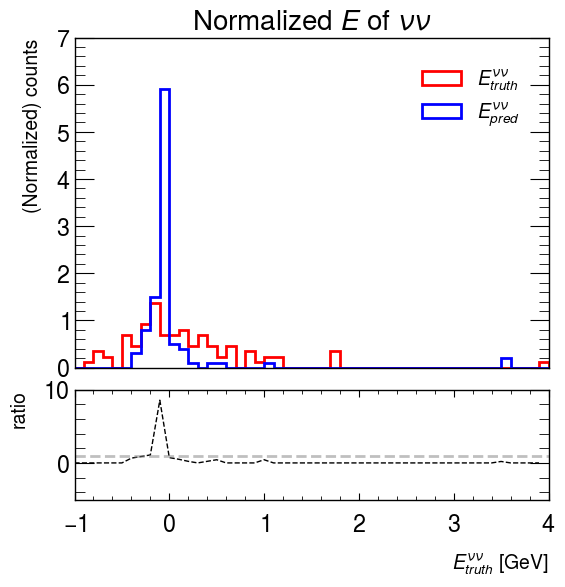

<Figure size 800x600 with 0 Axes>

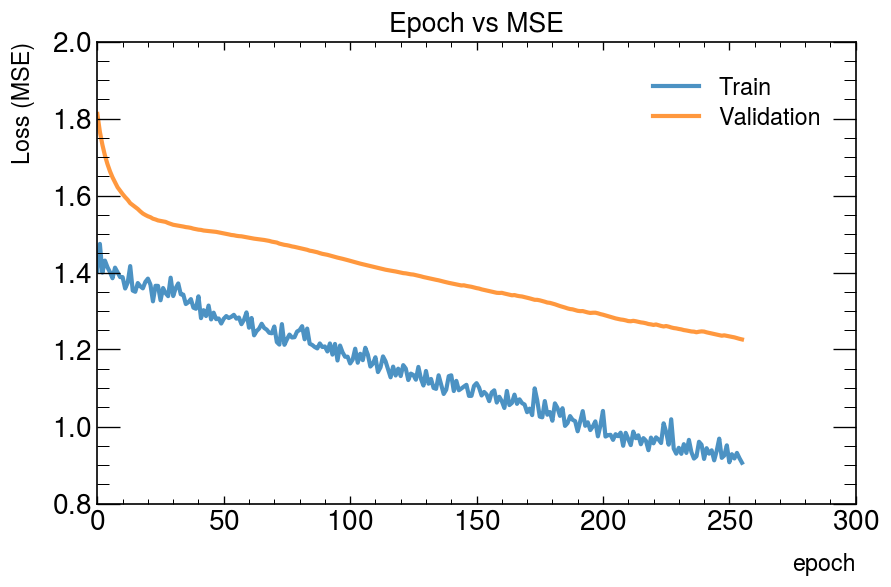

<Figure size 800x600 with 0 Axes>

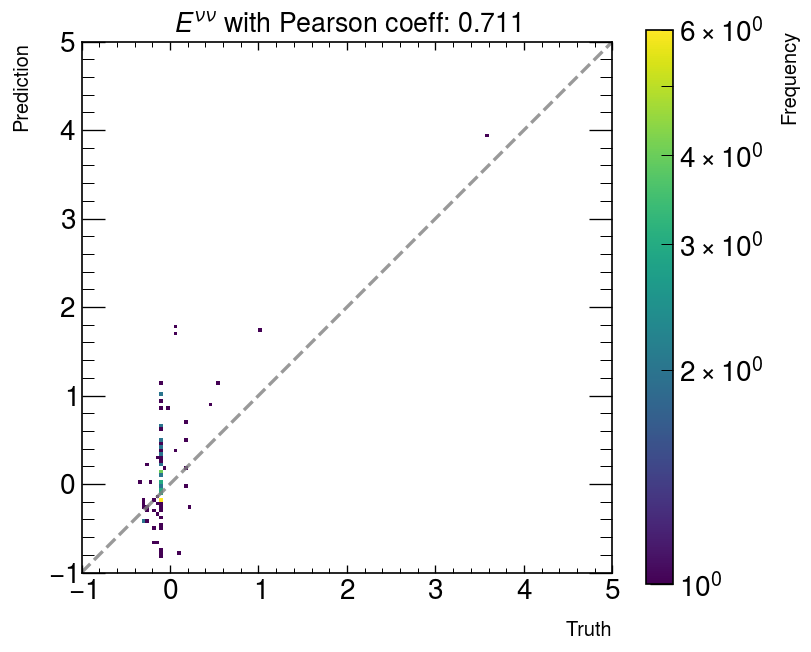

<Figure size 800x600 with 0 Axes>

In [10]:
plot = ap.Plotter()

plot.plot_hist(
    [E_truth, E_pred],
    [r"$E_{truth}^{\nu\nu}$", r"$E_{pred}^{\nu\nu}$"],
    r"Normalized $E$ of $\nu\nu$",
    [-1, 4],
)
plot.plot_loss_history(history)

import scipy as sp

plot.plot_2d_histogram(
    E_pred,
    E_truth,
    r"$E^{\nu\nu}$ " + f"with Pearson coeff: {sp.stats.pearsonr(E_truth, E_pred)[0]:.3f}",
    range=[-1, 5],
)